In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.utils import plot_model


from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Dropout

In [2]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    print()
    
def get_filetypes(filepath):
    exts = set(os.path.splitext(f)[1] for dir,dirs,files in os.walk(filepath) for f in files)
    print("File extentions on image directory: ", exts)
    return exts

def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))
    
    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)

In [3]:
file_exts = get_filetypes("C:/Users/Baradhan/forest_cnn/dataset/train")
train_path = "C:/Users/Baradhan/forest_cnn/dataset/train"
valid_path = "C:/Users/Baradhan/forest_cnn/dataset/valid"
test_path = "C:/Users/Baradhan/forest_cnn/dataset/test"

train_df = process_img(train_path)
val_df = process_img(valid_path)
test_df = process_img(test_path)

File extentions on image directory:  {'.jpg'}


In [4]:
walk_through_dir("/kaggle/input/wildfire-prediction-dataset")

img = cv2.imread(train_df.iloc[0].Filepath)
INPUT_SHAPE = img.shape
print(INPUT_SHAPE)


(350, 350, 3)


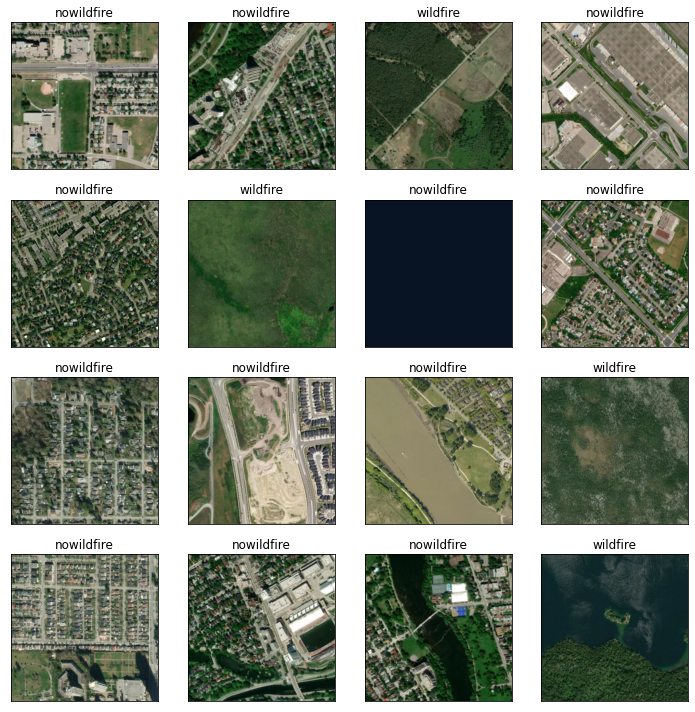

In [5]:
def show_image_sample(df):
    random_data = df.sample(n=16)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(random_data.iloc[i].Filepath))
        ax.set_title(random_data.iloc[i].Label)
    plt.tight_layout()
    plt.show()
    
show_image_sample(train_df)

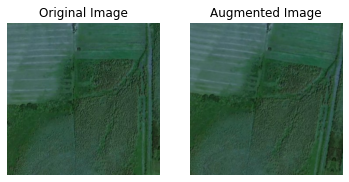

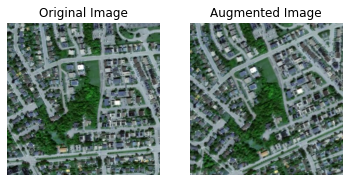

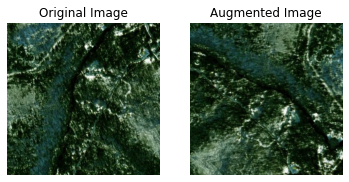

In [6]:
def augment_image(image):
    aug = A.Compose([
        A.Flip(),
        A.Rotate(limit=75,always_apply=True),
    ])
    augmented_image = aug(image=image)['image']
    return augmented_image

    
def show_original_augment_image(df):
    random_data = df.sample(n=3)
    for i in range(len(random_data)):
        image = cv2.imread(random_data.iloc[i].Filepath)
        augmented_image = augment_image(image)

        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Original Image")

        plt.subplot(1,2,2)
        plt.imshow(augmented_image)
        plt.title("Augmented Image")
        plt.axis('off')
        plt.show()

show_original_augment_image(train_df)

In [7]:
BATCH_SIZE =64
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=augment_image)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (64,64),
                                                    class_mode = 'binary')
val_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
val_generator = val_datagen.flow_from_dataframe(val_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (64,64),
                                                    class_mode = 'binary')
test_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=False,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (64,64),
                                                    class_mode = 'binary')

Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


In [8]:
weight_decay = 1e-3
image_shape = (64,64,3)

# building a sequential CNN model and adding layers to it
# dropout and the regularizer are used in general to prevent overfitting
models = Sequential([
    Conv2D(filters = 8 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 32 , kernel_size = 2, activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),
    
    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
# showing the summary of our model (layers and number of parameters)
models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 8)         104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0

In [9]:

plot_model(models,'forest.jpg',show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# checkpointer to save the model only if it improved
checkpointer = ModelCheckpoint('models.h5',verbose=1, save_best_only= True)
# early stopping to stop the training if our validation loss didn't decrease for (10) consecutive epochs
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
# Adam, best optimiser for deep learning models to help with the training
optimizer = optimizers.legacy.Adam(learning_rate= 0.00001, decay= 1e-5)
# setting our loss function and which metric to evaluate
models.compile(loss= 'binary_crossentropy', optimizer= optimizer,
                    metrics=['acc'])

# TRAIN
history = models.fit(train_generator,
                    epochs = 100,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
1891/1891 [==============================] - ETA: 0s - loss: 0.5382 - acc: 0.7304
Epoch 1: val_loss improved from inf to 0.36689, saving model to models.h5
1891/1891 [==============================] - 1006s 531ms/step - loss: 0.5382 - acc: 0.7304 - val_loss: 0.3669 - val_acc: 0.8571
Epoch 2/100
1891/1891 [==============================] - ETA: 0s - loss: 0.3007 - acc: 0.8934
Epoch 2: val_loss improved from 0.36689 to 0.31551, saving model to models.h5
1891/1891 [==============================] - 430s 227ms/step - loss: 0.3007 - acc: 0.8934 - val_loss: 0.3155 - val_acc: 0.8752
Epoch 3/100
1891/1891 [==============================] - ETA: 0s - loss: 0.2773 - acc: 0.8980
Epoch 3: val_loss did not improve from 0.31551
1891/1891 [==============================] - 334s 176ms/step - loss: 0.2773 - acc: 0.8980 - val_loss: 0.3242 - val_acc: 0.8724
Epoch 4/100
1891/1891 [==============================] - ETA: 0s - loss: 0.2698 - acc: 0.8993
Epoch 4: val_loss improved from 0.31551 to 

Epoch 30/100
1891/1891 [==============================] - ETA: 0s - loss: 0.2108 - acc: 0.9215
Epoch 30: val_loss did not improve from 0.22571
1891/1891 [==============================] - 97s 51ms/step - loss: 0.2108 - acc: 0.9215 - val_loss: 0.2432 - val_acc: 0.9084
Epoch 31/100
1891/1891 [==============================] - ETA: 0s - loss: 0.2094 - acc: 0.9213
Epoch 31: val_loss did not improve from 0.22571
1891/1891 [==============================] - 97s 51ms/step - loss: 0.2094 - acc: 0.9213 - val_loss: 0.2354 - val_acc: 0.9114
Epoch 32/100
1890/1891 [============================>.] - ETA: 0s - loss: 0.2070 - acc: 0.9223
Epoch 32: val_loss did not improve from 0.22571
1891/1891 [==============================] - 93s 49ms/step - loss: 0.2069 - acc: 0.9223 - val_loss: 0.2276 - val_acc: 0.9160
Epoch 33/100
1891/1891 [==============================] - ETA: 0s - loss: 0.2063 - acc: 0.9233
Epoch 33: val_loss did not improve from 0.22571
1891/1891 [==============================] - 94s 50ms

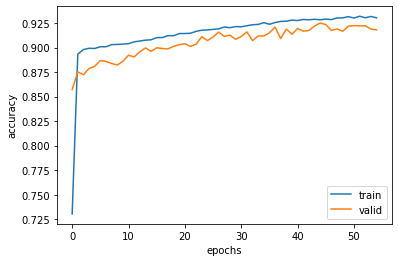

In [11]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

# adding legend and labels
plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# show the plot
plt.show()

In [13]:
loss,accuracy = models.evaluate(test_generator)


394/394 [==============================] - 68s 173ms/step - loss: 0.2138 - acc: 0.9294


In [14]:
print('Accuracy: %.2f%%' % (accuracy*100))

Accuracy: 92.94%


In [16]:
pred = np.argmax(models.predict(test_generator), axis=1)

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000002103BA24790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000002103BA24790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Orig

Accuracy score: 44.761904761904766


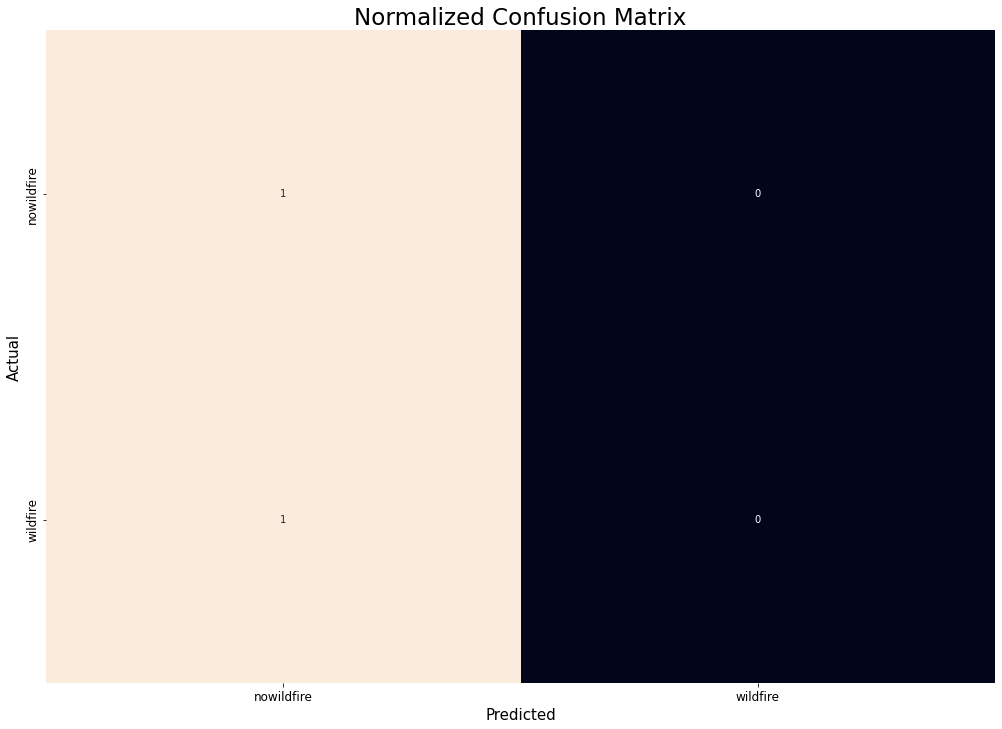

In [17]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_label = [labels[k] for k in pred]
y_test = list(test_df.Label)

# Print accuracy score
score = accuracy_score(y_test,pred_label)
print(f'Accuracy score: {score * 100}')

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, pred_label, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Actual", fontsize=15)
plt.show()

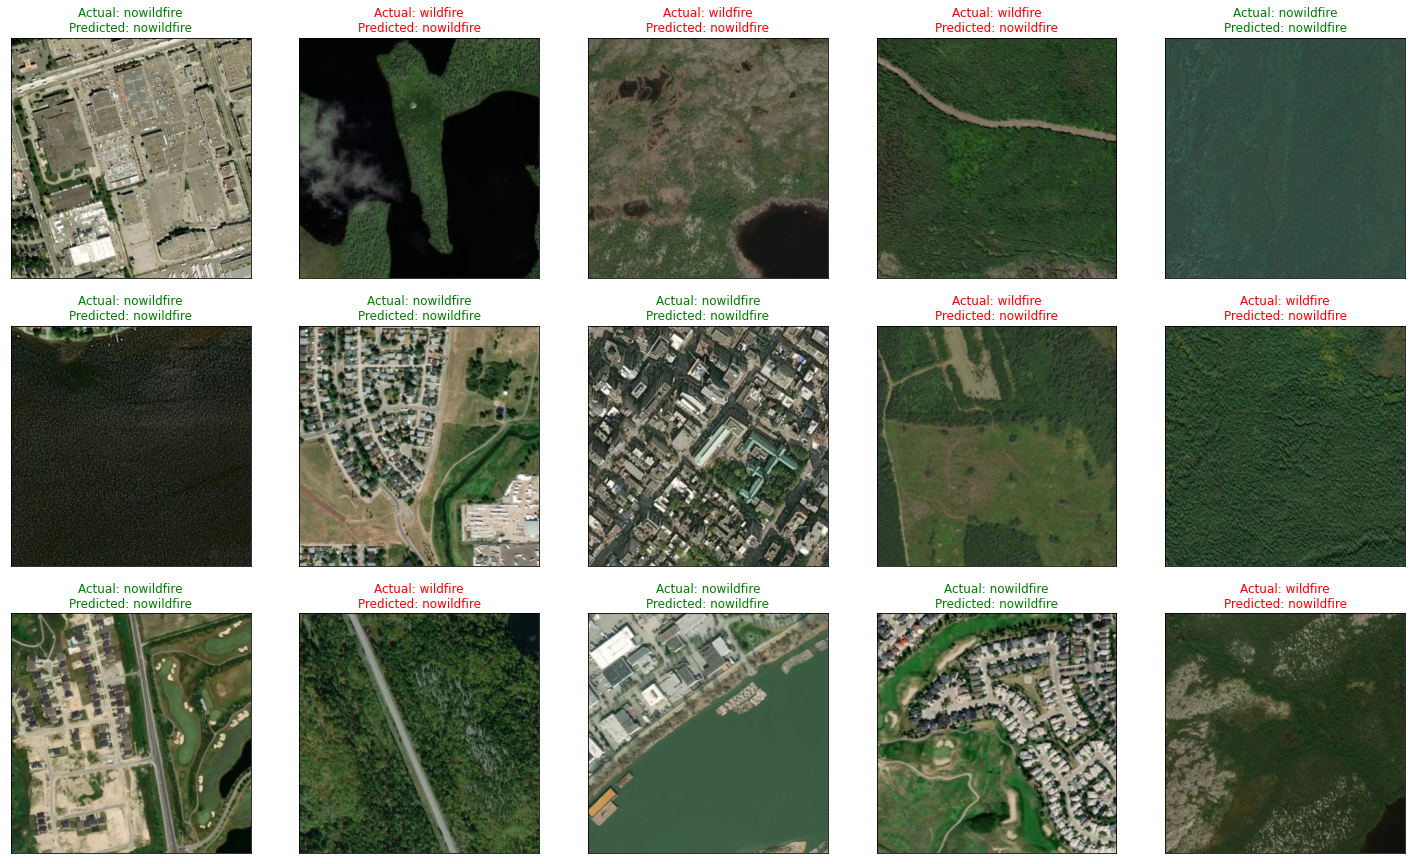

<Figure size 432x288 with 0 Axes>

In [18]:
# Show random images with predicted and actual values
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0, len(test_df) - 1, 15)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_generator.filepaths[random_index[i]]))
    if labels[test_generator.labels[random_index[i]]] == pred_label[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"Actual: {labels[test_generator.labels[random_index[i]]]}\nPredicted: {pred_label[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()